#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계1 : 데이터 탐색 및 전처리

## 0.미션

* 1) 데이터 탐색
    * intent 별 질문 개수 분포 확인하기
    * 질문 별 문장길이의 분포 확인하기
    * 대화 유형(type) 별 문장길이 분포 비교하기
    * 그 외 필요하다고 판단되는 부분에 대해 데이터를 탐색하고 분석하기
* 2) 전처리
    * 기본 전처리 : 데이터를 불러온 후 다음의 전처리를 먼저 수행합니다.
        * 한글 칼럼이름을 영문이름으로 변경하기
        * 두 데이터셋을 하나로 통합하기
        * intent 번호를 통합된 번호로 만들기
        * 일상대화와 Q&A 대화를 구분하는 구분자 칼럼 추가하기
    * 학습을 위한 전처리 : 자연어 처리를 위한 전처리를 수행합니다.
        * 형태소 분석기를 활용하여 문장 어절들에 대해 형태소로 변환합니다.
    * 전처리 결과를 저장합니다.

## 1.환경준비

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.
    - 구글드라이브 를 통해 데이터를 로딩합니다.

### (1) 라이브러리 불러오기

In [ ]:
# 필요 라이브러리 설치
!pip install konlpy gensim wget
!pip install mecab-python

# 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os
from mecab import MeCab
from konlpy.tag import Okt
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.font_manager as fm
import wget, os

In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 챗봇 데이터.xls
    * 학습 데이터 : 일상대화.xls
    * 엑셀 파일이므로 pd.read_excel 함수를 이용해서 불러 옵니다.
* Colab 환경에서 프로젝트 진행을 권장합니다.
    * 구글 드라이브에 project 폴더를 만들고 데이터 파일을 복사해 넣습니다.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/'

### (3) 데이터 읽어오기

In [ ]:
# 일상대화
common_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/일상대화.xlsx')

# 에이블스쿨 질문답변
faq_df =  pd.read_excel('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/챗봇데이터.xlsx')

* 데이터 둘러보기

In [ ]:
display(common_df.tail())
print("="*200)
display(faq_df.tail())

,intent,질문,답변
501,30,나 오늘 생일이야~,기분 좋겠어요.
502,30,원하던 대학교에 합격했어,기분 좋겠어요.
503,30,편입 성공했어!!,기분 좋겠어요.
504,30,고백 성공해서 오늘부터 1일이야~,기분 좋겠어요.
505,30,이번에 적금해지해서 돈 생겼다!,기분 좋겠어요.


,intent,Q,A
787,22,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
788,22,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
789,22,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
790,22,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
791,22,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...


## 2.데이터 탐색하기


* **세부 요구사항**
    * 데이터에 대한 기본 전처리를 수행합니다.
        * (필요시)한글 칼럼명을 영문명으로 변경,
        * 두 데이터셋 하나로 통합
        * 일상대화와 지원Q&A를 구분할 대화유형(type)칼럼 생성
    * 데이터 탐색하기
        * intent별 질문 수 확인
        * 각 질문별 문장길이에 대한 분포 확인
        * 대화유형(type)별 문장길이 분포 확인
        * 그외, 필요하다고 생각되는 탐색적 분석 수행

### (1) 데이터 기본 전처리

#### 1) column이름 통일하기(선택사항)
* 필수는 아니지만, 한글 칼럼명을 영문으로 변경합니다.

In [ ]:
# common_df의 컬럼 이름을 변경합니다. '질문'을 'Q'로, '답변'을 'A'로 변경
common_df.rename(columns = {'질문':'Q', '답변':'A'}, inplace=True)
common_df['type'] = '0'
common_df

,intent,Q,A,type
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0
1,1,액정 나갔어,as 맡기세요.,0
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0
...,...,...,...,...
501,30,나 오늘 생일이야~,기분 좋겠어요.,0
502,30,원하던 대학교에 합격했어,기분 좋겠어요.,0
503,30,편입 성공했어!!,기분 좋겠어요.,0
504,30,고백 성공해서 오늘부터 1일이야~,기분 좋겠어요.,0


#### 2) 데이터셋 통합
* intent 다시 번호 부여하기
    * 두 데이터의 intent 번호를 확인합니다.
    * 변경
        * common_df : 1 부터 시작되도록 하고
        * faq_df : common_df의 마지막 intent 이후부터 시작되도록 수정
* 두 데이터 셋을 통합합니다. (pd.concat)

* intent 번호 조정

In [ ]:
faq_df['intent'] = faq_df['intent']+31
faq_df['type'] = '1'

* 데이터셋 통합(pd.concat)

In [ ]:
data = pd.concat([common_df, faq_df])

In [ ]:
data.tail()

,intent,Q,A,type
787,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
788,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
789,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
790,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
791,53,다른 교육보다 특별한 것이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


In [ ]:
data.to_csv(path + 'total_data.csv', index=False)

#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류입니다.
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정하시오.

In [ ]:
# 상단에서 이미 추가

### (2) 데이터 탐색하기


* 세부 요구사항
    - intent별 질문 개수 분포를 확인합니다.
        * 문의 유형별 길이에 대한 기초통계량과  시각화(히스토그램, 박스플롯 등)를 통해 분포를 확인합니다.
    - 질문별 문장 길이 분포를 확인합니다.

#### 1) intent별 질문 개수 살펴보기
* intent 별 데이터 개수를 bar plot 등을 이용하여 시각화 합니다.

In [ ]:
intent_counts = data['intent'].value_counts()

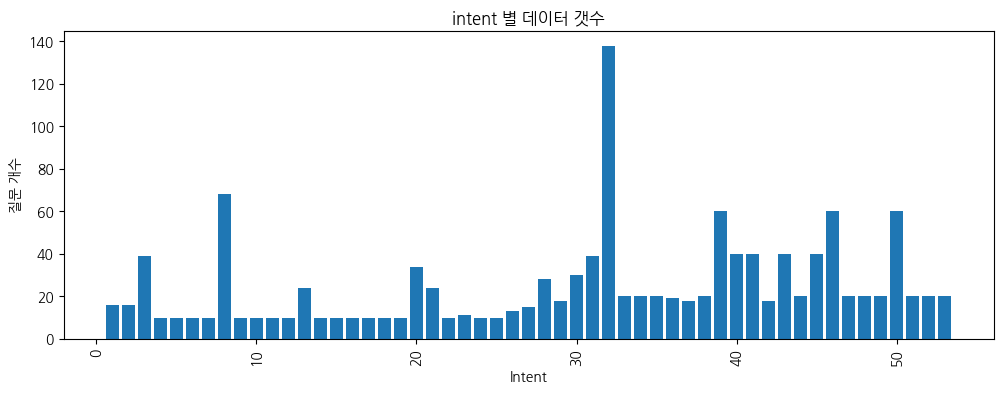

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(intent_counts.index, intent_counts.values)
plt.xlabel('Intent')
plt.ylabel('질문 개수')
plt.title('intent 별 데이터 갯수')
plt.xticks(rotation=90)  # x 축 레이블을 90도 회전시킵니다
plt.show()

#### 2) 질문별 문장 길이 분포
* 질문 별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

In [ ]:
data['Q_Length'] = data['Q'].apply(len)

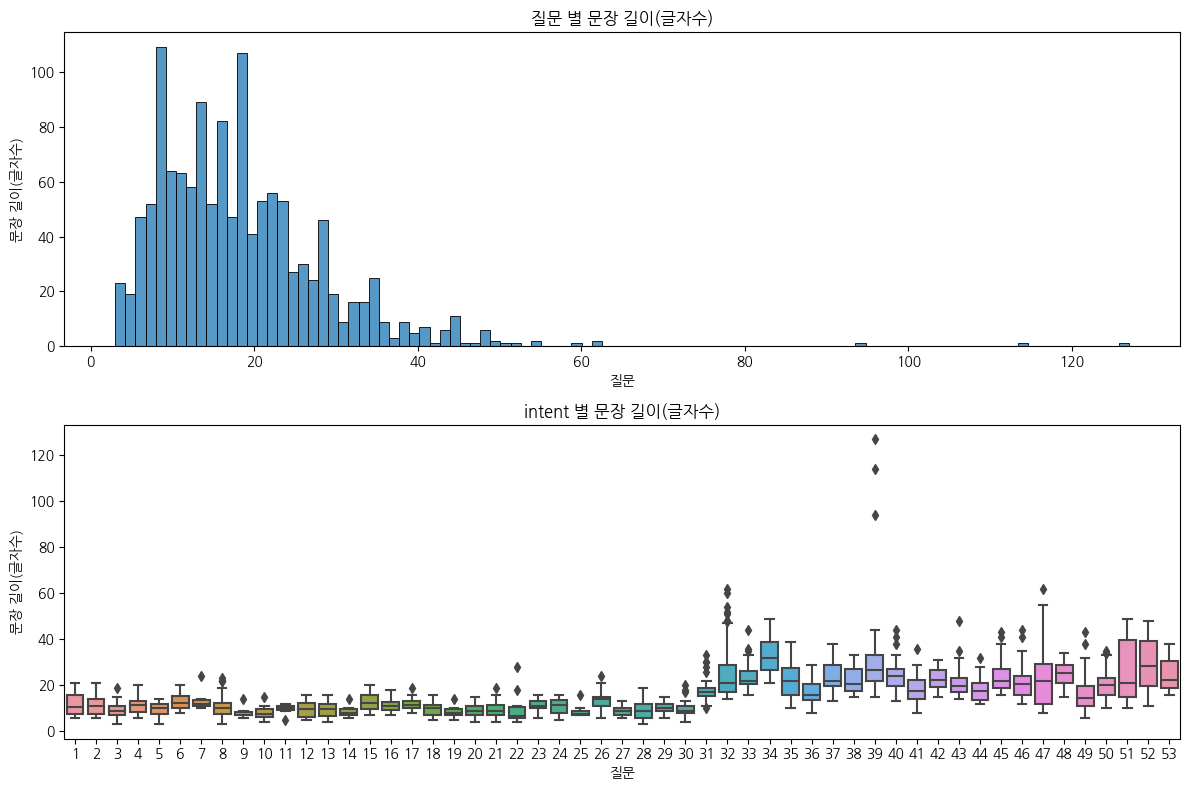

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
sns.histplot(x=data['Q_Length'], bins=100)
plt.xlabel('질문')
plt.ylabel('문장 길이(글자수)')
plt.title('질문 별 문장 길이(글자수)')

plt.subplot(2,1,2)
sns.boxplot(x=data['intent'], y=data['Q_Length'])
plt.xlabel('질문')
plt.ylabel('문장 길이(글자수)')
plt.title('intent 별 문장 길이(글자수)')

plt.tight_layout()  # 그래프 간격 조정
plt.show()

#### 3) 대화 유형(type) 별 문장 길이 분포 비교
* 타입별 문장 길이(글자 수)를 추출하여 분포를 살펴봅시다.
    * 기초 통계량
    * 히스토그램 및 박스 플롯으로 분포를 살펴봅니다.

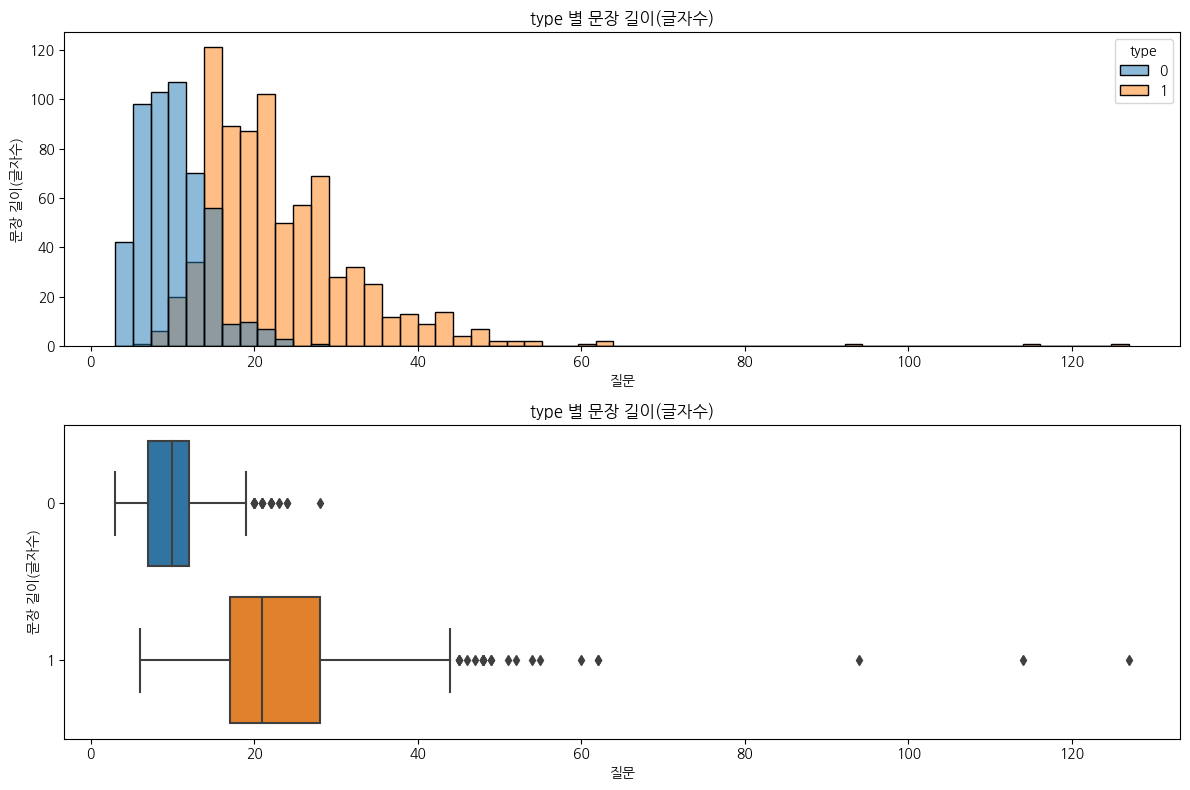

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
sns.histplot(data=data, x="Q_Length", hue="type")
plt.xlabel('질문')
plt.ylabel('문장 길이(글자수)')
plt.title('type 별 문장 길이(글자수)')


plt.subplot(2,1,2)
sns.boxplot(data= data, y='type', x='Q_Length')
plt.xlabel('질문')
plt.ylabel('문장 길이(글자수)')
plt.title('type 별 문장 길이(글자수)')
plt.tight_layout()  # 그래프 간격 조정
plt.show()

## 3.데이터 전처리

* 세부요구사항
    * 다음 항목에 해당되는 전처리 함수를 각각 생성하여 하나로 합쳐봅시다.
        * 특수문자 제거 : 정규 표현식을 활용합니다. (띄어쓰기, \n 등)
        * 형태소 분석기 사용 : konlpy(mecab, kkma, Okt, etc), soynlp, khaiii 등 여러 형태소 분석기를 활용합니다.
    * 문장길이를 조절하여 모델 input으로 활용하기
    * joblib.dump를 이용하여 전처리 결과 데이터를 저장합니다.

### (1) 학습/평가 데이터 분리
   * test 데이터 : intent마다 무작위로 질문 2개를 뽑아 test 데이터로 분리
   * train 데이터 : 나머지 데이터


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, stratify=data['intent'], test_size=0.1, random_state=42)

### (2) 형태소 분석하기
- konlpy, mecab 설치 후 형태소 분석 함수 생성
    * Colab에서는 아래 두 코드셀을 순차적으로 실행하면 설치 됩니다.
        * 참조 : https://konlpy.org/en/latest/install/
- 형태소 분석 결과를 다음의 이름으로 생성하시오.
    - clean_train_questions
    - clean_test_questions

#### 1) 형태소 분석 패키지 설치

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

#### 2) 형태소 분석을 위한 함수를 제공합니다.

In [ ]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()

    return tokenizer

In [ ]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)

    return tokenized_sent

#### 3) 형태소 분석 테스트
* 몇개 데이터에 대해 형태소 분석 확인하기

#### 4) train, test의 Q에 대해 형태소 분석하여 저장하기
* 데이터프레임의 각 행 별로 함수를 적용하는 방법
    * .apply(lambda ..........) 를 활용하면 손쉽게 처리할수 있습니다.

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/'

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, stratify=data['intent'], test_size=0.1, random_state=42)

In [ ]:
clean_train_questions_mecab =  train['Q'].apply(lambda x: tokenize('mecab', x, nouns=False))
clean_test_questions_mecab = test['Q'].apply(lambda x: tokenize('mecab', x, nouns=False))

# clean_train_questions_mecab를 데이터프레임으로 변환
clean_train_questions_mecab_df = pd.DataFrame(clean_train_questions_mecab, columns=['Q'])
clean_test_questions_mecab_df = pd.DataFrame(clean_test_questions_mecab, columns=['Q'])

train['Q'] = clean_train_questions_mecab_df
test['Q'] = clean_test_questions_mecab_df

# mecab 데이터 저장
joblib.dump(train, path + 'train_data_mecab.pkl')
joblib.dump(test, path + 'test_data_mecab.pkl')

['/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/test_data_mecab.pkl']

In [ ]:
clean_train_questions_okt =  train['Q'].apply(lambda x: tokenize('okt', x, nouns=False))
clean_test_questions_okt = test['Q'].apply(lambda x: tokenize('okt', x, nouns=False))

# clean_train_questions_mecab를 데이터프레임으로 변환
clean_train_questions_okt_df = pd.DataFrame(clean_train_questions_okt, columns=['Q'])
clean_test_questions_okt_df = pd.DataFrame(clean_test_questions_okt, columns=['Q'])

train['Q'] = clean_train_questions_okt_df
test['Q'] = clean_test_questions_okt_df

# mecab 데이터 저장
joblib.dump(train, path + 'train_data_okt.pkl')
joblib.dump(test, path + 'test_data_okt.pkl')

['/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/test_data_okt.pkl']

In [ ]:
clean_train_questions_hannanum =  train['Q'].apply(lambda x: tokenize('hannanum', x, nouns=False))
clean_test_questions_hannanum = test['Q'].apply(lambda x: tokenize('hannanum', x, nouns=False))

# clean_train_questions_mecab를 데이터프레임으로 변환
clean_train_questions_hannanum_df = pd.DataFrame(clean_train_questions_hannanum, columns=['Q'])
clean_test_questions_hannanum_df = pd.DataFrame(clean_test_questions_hannanum, columns=['Q'])

train['Q'] = clean_train_questions_hannanum_df
test['Q'] = clean_test_questions_hannanum_df

# mecab 데이터 저장
joblib.dump(train, path + 'train_data_hannanum.pkl')
joblib.dump(test, path + 'test_data_hannanum.pkl')

['/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/test_data_hannanum.pkl']

In [ ]:
clean_train_questions_komoran =  train['Q'].apply(lambda x: tokenize('komoran', x, nouns=False))
clean_test_questions_komoran = test['Q'].apply(lambda x: tokenize('komoran', x, nouns=False))

# clean_train_questions_mecab를 데이터프레임으로 변환
clean_train_questions_komoran_df = pd.DataFrame(clean_train_questions_komoran, columns=['Q'])
clean_test_questions_komoran_df = pd.DataFrame(clean_test_questions_komoran, columns=['Q'])

train['Q'] = clean_train_questions_komoran_df
test['Q'] = clean_test_questions_komoran_df

# mecab 데이터 저장
joblib.dump(train, path + 'train_data_komoran.pkl')
joblib.dump(test, path + 'test_data_komoran.pkl')

['/content/drive/MyDrive/Colab Notebooks/KT AIVLE/미니 프로젝트/6차 미프/데이터/test_data_komoran.pkl']

### (3) 전처리 완료된 데이터를 파일로 저장하기
- 총 4개의 파일을 저장합니다.
    * train 셋
    * test 셋
    * 전처리된 데이터
        * clean_train_questions
        * clean_test_questions
- 저장방법
    * joblib 라이브러리를 이용하여 저장합니다.

In [ ]:
# 이미 다 저장함!